In [328]:
import os
import h5py
import torch
import numpy as np
from importlib import reload

import main
reload(main)
from main import main

## Loading data into notebook

In [329]:
def extract_data(filepath: str) -> dict:
    """
    For a .h5 file specified by a filepath, this function returns
    data in the form of a dictionary.
    """

    results = {}
    with h5py.File(filepath, "r") as f:
        for key in f.keys():
            if type(f[key]) == h5py.Dataset:
                ds_arr = f[key][()]  # returns as a numpy array
                results[key] = ds_arr

            elif type(f[key]) == h5py.Group:
                group = f.get(key)
                gdict = {}
                for gkey in group.keys():
                    ds_arr = group[gkey][()]
                    gdict[gkey] = ds_arr
                results[key] = gdict

    return results

In [330]:
# Load raw data
path = "./data/raw_data"

files = [f for f in os.listdir(path) if "oasis_output_Venus_" in f]

outputs = {}
timesteps = []
# Loads all output files and saves them within some object
for f in files: 
    timestep = int(f.split("Venus_")[1].split(".h5")[0])
    timesteps.append(timestep)
    
    output = extract_data(os.path.join(path, f))
    output["timestep"] = timestep
    outputs[timestep] = output

In [331]:
# For each timestep, get targets
tgt_labels = [
    "fnet_dn_sw_h",
    "fnet_up_sw_h",
    "fnet_dn_lw_h",
    "fnet_up_lw_h",
]
targets = {}
for timestep, output in outputs.items():
    targets[timestep] = {}
    for lbl in tgt_labels:
        targets[timestep][lbl] = output[lbl]

# Choose a timestep
ts = timesteps[0]

In [332]:
print("Target shape: ", targets[ts]["fnet_dn_sw_h"].shape)
print("Target type: ", type(targets[ts]["fnet_dn_sw_h"]))

Target shape:  (512100,)
Target type:  <class 'numpy.ndarray'>


In [333]:
Pressure = np.copy(outputs[ts]["Pressure"])
Temperature = np.copy(outputs[ts]["Temperature"])
Rho = np.copy(outputs[ts]["Rho"])
sTemperature = np.copy(outputs[ts]["sTemperature"])
cosz = np.copy(outputs[ts]["cosz"])
alb_surf_sw = np.copy(outputs[ts]["alb_surf_sw"])
alb_surf_lw = np.copy(outputs[ts]["alb_surf_lw"])

In [334]:
ncol, nlay = 10242, 49
nlev = nlay + 1

## Getting predictions

In [335]:
fnet_dn_sw_h_pred, fnet_up_sw_h_pred, fnet_dn_lw_h_pred, fnet_up_lw_h_pred = main(
    Pressure, Temperature, Rho, sTemperature, cosz, alb_surf_sw, alb_surf_lw)

3/3 [==============================] - 1s 264ms/step


## Plotting predictions

In [336]:
fnet_dn_sw_h_pred = np.reshape(fnet_dn_sw_h_pred, newshape=(ncol, nlev))
fnet_up_sw_h_pred = np.reshape(fnet_up_sw_h_pred, newshape=(ncol, nlev))
fnet_dn_lw_h_pred = np.reshape(fnet_dn_lw_h_pred, newshape=(ncol, nlev))
fnet_up_lw_h_pred = np.reshape(fnet_up_lw_h_pred, newshape=(ncol, nlev))

In [337]:
fnet_dn_sw_h = np.reshape(targets[ts]['fnet_dn_sw_h'], newshape=(ncol, nlev))
fnet_up_sw_h = np.reshape(targets[ts]['fnet_up_sw_h'], newshape=(ncol, nlev))
fnet_dn_lw_h = np.reshape(targets[ts]['fnet_dn_lw_h'], newshape=(ncol, nlev))
fnet_up_lw_h = np.reshape(targets[ts]['fnet_up_lw_h'], newshape=(ncol, nlev))

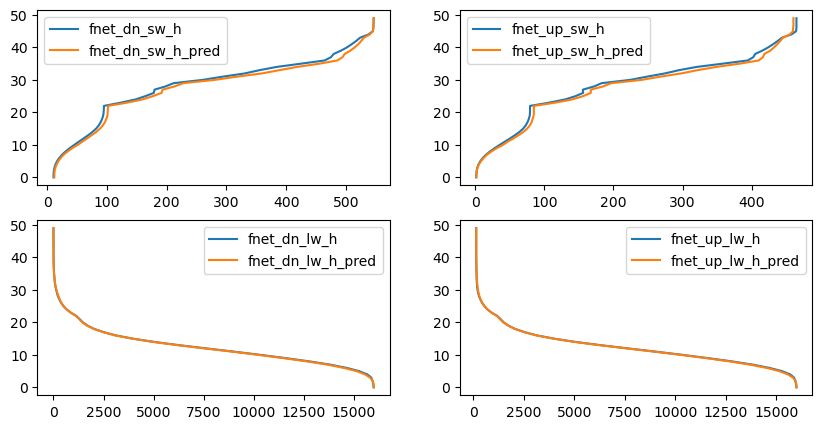

In [338]:
col = 999

# For col, plot two subplots of fnet_dn_sw_h and fnet_up_sw_h
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].plot(fnet_dn_sw_h[col, :], range(50), label="fnet_dn_sw_h")
ax[0, 0].plot(fnet_dn_sw_h_pred[col, :], range(50), label="fnet_dn_sw_h_pred")
ax[0, 0].legend()

ax[0, 1].plot(fnet_up_sw_h[col, :], range(50), label="fnet_up_sw_h")
ax[0, 1].plot(fnet_up_sw_h_pred[col, :], range(50), label="fnet_up_sw_h_pred")
ax[0, 1].legend()

ax[1, 0].plot(fnet_dn_lw_h[col, :], range(50), label="fnet_dn_lw_h")
ax[1, 0].plot(fnet_dn_lw_h_pred[col, :], range(50), label="fnet_dn_lw_h_pred")
ax[1, 0].legend()

ax[1, 1].plot(fnet_up_lw_h[col, :], range(50), label="fnet_up_lw_h")
ax[1, 1].plot(fnet_up_lw_h_pred[col, :], range(50), label="fnet_up_lw_h_pred")
ax[1, 1].legend()

plt.show()